#Extração do Arquivo Tratado

In [1]:
import pandas as pd
import json

# Carregar o arquivo JSON
with open("/content/TelecomX_Data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Normalizar os dados aninhados
df = pd.json_normalize(data)

# Selecionar e renomear colunas relevantes
df_clean = df[[
    "customerID", "Churn",
    "customer.gender", "customer.SeniorCitizen", "customer.Partner", "customer.Dependents", "customer.tenure",
    "phone.PhoneService", "phone.MultipleLines",
    "internet.InternetService", "internet.OnlineSecurity", "internet.OnlineBackup", "internet.DeviceProtection",
    "internet.TechSupport", "internet.StreamingTV", "internet.StreamingMovies",
    "account.Contract", "account.PaperlessBilling", "account.PaymentMethod",
    "account.Charges.Monthly", "account.Charges.Total"
]].copy()

df_clean.columns = [
    "customerID", "Churn", "Gender", "SeniorCitizen", "Partner", "Dependents", "Tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod", "MonthlyCharges", "TotalCharges"
]

# Corrigir tipo de dado e valores ausentes
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

# Salvar em CSV
df_clean.to_csv("TelecomX_Data_CLEAN.csv", index=False)

print("Arquivo exportado com sucesso como TelecomX_Data_CLEAN.csv!")


Arquivo exportado com sucesso como TelecomX_Data_CLEAN.csv!


#Remoção de Colunas Irrelevantes


In [2]:
# Remove identificadores únicos que não agregam valor preditivo
df_clean = df_clean.drop(columns=["customerID"])

# Verifica as primeiras linhas
print(df_clean.head())


  Churn  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0    No  Female              0     Yes        Yes       9          Yes   
1    No    Male              0      No         No       9          Yes   
2   Yes    Male              0      No         No       4          Yes   
3   Yes    Male              1     Yes         No      13          Yes   
4   Yes  Female              1     Yes         No       3          Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No          Yes               No   
1           Yes             DSL             No           No               No   
2            No     Fiber optic             No           No              Yes   
3            No     Fiber optic             No          Yes              Yes   
4            No     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling

# transformação com One-Hot Encoding:

In [3]:
# 7. Mapeia colunas binárias "Yes"/"No" para 1/0
bin_cols = ["Churn", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]
df_clean[bin_cols] = df_clean[bin_cols].replace({"Yes": 1, "No": 0})

# 8. One-Hot Encoding nas variáveis categóricas
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# 9. Exibe as primeiras linhas
print(df_encoded.head())

   SeniorCitizen  Partner  Dependents  Tenure  PhoneService  PaperlessBilling  \
0              0        1           1       9             1                 1   
1              0        0           0       9             1                 0   
2              0        0           0       4             1                 1   
3              1        1           0      13             1                 1   
4              1        1           0       3             1                 1   

   MonthlyCharges  TotalCharges  Churn_1  Churn_  ...  TechSupport_Yes  \
0            65.6        593.30    False   False  ...             True   
1            59.9        542.40    False   False  ...            False   
2            73.9        280.85     True   False  ...            False   
3            98.0       1237.85     True   False  ...            False   
4            83.9        267.40     True   False  ...             True   

   StreamingTV_No internet service  StreamingTV_Yes  \
0            

/tmp/ipython-input-538188625.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[bin_cols] = df_clean[bin_cols].replace({"Yes": 1, "No": 0})


# proporção e verificação de desequilíbrio

In [4]:
# Contar ocorrências de cada classe
churn_counts = df_clean["Churn"].value_counts()

# Calcular proporção
churn_proportion = df_clean["Churn"].value_counts(normalize=True)

# Exibir os resultados
print("Contagem de clientes:")
print(churn_counts)

print("\nProporção de classes:")
print(churn_proportion)

# Avaliar se há desequilíbrio
threshold = 0.60  # exemplo: se uma classe tiver mais de 60%, considera-se desbalanceado

if churn_proportion.max() > threshold:
    print("\n Desequilíbrio detectado: Uma das classes é dominante.")
else:
    print("\n As classes estão relativamente balanceadas.")


Contagem de clientes:
Churn
0    5174
1    1869
      224
Name: count, dtype: int64

Proporção de classes:
Churn
0    0.711986
1    0.257190
     0.030824
Name: proportion, dtype: float64

 Desequilíbrio detectado: Uma das classes é dominante.


# Balanceamento de Classes

In [5]:
if "Churn" not in df_encoded.columns and "Churn" in df_clean.columns:
    df_encoded["Churn"] = df_clean["Churn"]


In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.impute import SimpleImputer

# Converter a coluna 'Churn' em numérica, forçando erros
df_encoded["Churn"] = pd.to_numeric(df_encoded["Churn"], errors="coerce")

# Descartar linhas onde 'Churn' é NaN (que eram as strings vazias)
df_encoded.dropna(subset=["Churn"], inplace=True)

# Cconverter 'Char' para tipo inteiro
df_encoded["Churn"] = df_encoded["Churn"].astype(int)

# Separar features (X) e target (y)
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]


# Separar treino/teste antes de balancear
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

print("Distribuição antes do balanceamento:", Counter(y_train))

# Impute missing values in X_train
imputer = SimpleImputer(strategy='mean') # or 'median', 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train)

# === 1. OVERSAMPLING com SMOTE ===
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_imputed, y_train)
print("Após SMOTE:", Counter(y_smote))

# Impute missing values in X_test para uso posterior (embora não seja usado nesta célula)
X_test_imputed = imputer.transform(X_test)

# === 2. UNDERSAMPLING ===
under = RandomUnderSampler(random_state=42)
X_under, y_under = under.fit_resample(X_train_imputed, y_train)
print("Após Undersampling:", Counter(y_under))

Distribuição antes do balanceamento: Counter({0: 3622, 1: 1308})
Após SMOTE: Counter({0: 3622, 1: 3622})
Após Undersampling: Counter({0: 1308, 1: 1308})


# Análise de Correlação

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a matriz de correlação
correlation_matrix = df_encoded.corr(numeric_only=True)

# Exibir apenas correlações com a variável alvo: Churn
churn_corr = correlation_matrix["Churn"].sort_values(ascending=False)

print("Correlação com 'Churn':")
print(churn_corr)



Correlação com 'Churn':
Churn_1                                  1.000000
Churn                                    1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
PhoneService                             0.011942
Gender_Male                             -0.008612
MultipleLines_No phone service          -0.011942
DeviceProtection_Yes                    -0.066160
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport_Yes           

# Análises Direcionadas

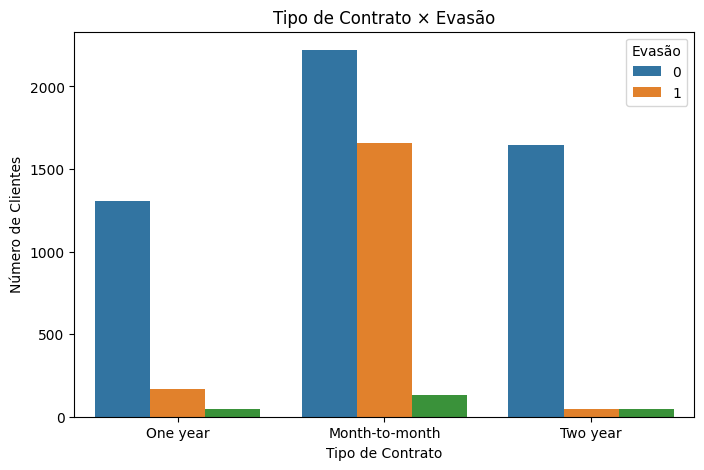

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: Tipo de Contrato × Evasão
plt.figure(figsize=(8, 5))
sns.countplot(x="Contract", hue="Churn", data=df_clean)
plt.title("Tipo de Contrato × Evasão")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Número de Clientes")
plt.legend(title="Evasão")
plt.show()


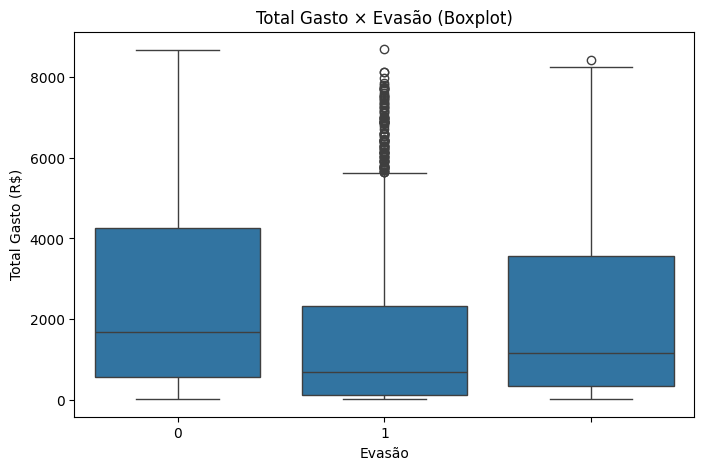

In [9]:
# Gráfico 2: Total Gasto × Evasão (Boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(x="Churn", y="TotalCharges", data=df_clean)
plt.title("Total Gasto × Evasão (Boxplot)")
plt.xlabel("Evasão")
plt.ylabel("Total Gasto (R$)")
plt.show()


# Separação de Dados

In [10]:
# Substituir strings vazias ou espaços por NaN
df_clean["Churn"] = df_clean["Churn"].replace({"": None, " ": None})

# Remover registros com Churn nulo ou inválido
df_clean = df_clean[df_clean["Churn"].notna()]

# Agora sim: mapear para 0 e 1 e converter para int
df_clean["Churn"] = df_clean["Churn"].replace({"Yes": 1, "No": 0}).astype(int)


/tmp/ipython-input-1219644642.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["Churn"] = df_clean["Churn"].replace({"Yes": 1, "No": 0}).astype(int)


In [11]:
# Converter Churn para 1 (Yes) e 0 (No)
df_clean["Churn"] = df_clean["Churn"].replace({"Yes": 1, "No": 0}).astype(int)

# Salvar a variável alvo (Churn)
target = df_clean["Churn"]

# Codificar variáveis categóricas
features = df_clean.drop("Churn", axis=1)
features_encoded = pd.get_dummies(features, drop_first=True)

# Juntar features codificadas com target
df_encoded = pd.concat([features_encoded, target], axis=1)

# Separar X e y
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

# Garantir que y é int (reforçando)
y = y.astype(int)

# Dividir os dados
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Mostrar tamanhos
X_train.shape, X_test.shape



((4930, 30), (2113, 30))

# Criação de Modelos

In [12]:
# modelo regressao logistica(com normalização)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Remover linhas com valores ausentes
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

# Treinar modelo
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train_clean)

# Avaliação
from sklearn.metrics import classification_report, confusion_matrix
y_pred_log = log_model.predict(X_test_scaled)
print(confusion_matrix(y_test_clean, y_pred_log))
print(classification_report(y_test_clean, y_pred_log))


[[1377  173]
 [ 255  306]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1550
           1       0.64      0.55      0.59       561

    accuracy                           0.80      2111
   macro avg       0.74      0.72      0.73      2111
weighted avg       0.79      0.80      0.79      2111



In [13]:
# modelo random forest (sem normalizacao)

from sklearn.ensemble import RandomForestClassifier

# Treinar modelo
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Avaliação
y_pred_rf = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[1387  165]
 [ 292  269]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.62      0.48      0.54       561

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113



# justificativa

Para Modelo Regressão Logística é devido um modelo simples e interpretável, ideal para tarefas de classificação binária como prever se um cliente vai ou não evadir (churn). Requeriu a normalização uma vez que é sensível à escala dos dados.

E por fim para o modelo Random Forest é por conta do modelo robusto e poderoso para classificação, mesmo com dados complexos e não linearmente separáveis. Não exigiu a normalização visto que é baseado em árvores de decisão, que tomam decisões por divisões nos valores das variáveis (splits).

# Avaliação dos Modelos

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Avaliação do modelo de Regressão Logística
print("Avaliação: Regressão Logística")
print("Acurácia:", accuracy_score(y_test_clean, y_pred_log))
print("Precisão:", precision_score(y_test_clean, y_pred_log))
print("Recall:", recall_score(y_test_clean, y_pred_log))
print("F1-score:", f1_score(y_test_clean, y_pred_log))
print("Matriz de Confusão:")
print(confusion_matrix(y_test_clean, y_pred_log))
print("\nRelatório de Classificação:\n")
print(classification_report(y_test_clean, y_pred_log))


Avaliação: Regressão Logística
Acurácia: 0.7972524869729986
Precisão: 0.6388308977035491
Recall: 0.5454545454545454
F1-score: 0.5884615384615385
Matriz de Confusão:
[[1377  173]
 [ 255  306]]

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1550
           1       0.64      0.55      0.59       561

    accuracy                           0.80      2111
   macro avg       0.74      0.72      0.73      2111
weighted avg       0.79      0.80      0.79      2111



In [15]:
# Avaliação do modelo Random Forest
print("Avaliação: Random Forest")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Precisão:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred_rf))


Avaliação: Random Forest
Acurácia: 0.783719829626124
Precisão: 0.619815668202765
Recall: 0.47950089126559714
F1-score: 0.5407035175879397
Matriz de Confusão:
[[1387  165]
 [ 292  269]]

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.62      0.48      0.54       561

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113



# Comparação geral de desempenho:

Regressão Logística tende a apresentar métricas equilibradas, mas como é um modelo linear, pode ter dificuldade com relações não-lineares entre variáveis.

Random Forest geralmente tem acurácia mais alta e captura padrões mais complexos porque combina várias árvores de decisão.



# Análise de Importância das Variáveis

Regressão Logística:

Como é um modelo linear, os coeficientes (coef_) indicam o peso de cada variável na previsão.

Sinal positivo → aumenta a probabilidade de churn.

Sinal negativo → reduz a probabilidade de churn.

In [16]:
# Coeficientes da Regressão Logística
coef_df = pd.DataFrame({
    "Variável": X.columns,
    "Coeficiente": log_model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

print("Variáveis mais influentes - Regressão Logística:")
print(coef_df.head(10))


Variáveis mais influentes - Regressão Logística:
                          Variável  Coeficiente
7                     TotalCharges     0.735544
11     InternetService_Fiber optic     0.556234
5                 PaperlessBilling     0.201971
28  PaymentMethod_Electronic check     0.172715
22                 StreamingTV_Yes     0.170200
10               MultipleLines_Yes     0.165556
24             StreamingMovies_Yes     0.149195
0                    SeniorCitizen     0.063049
9   MultipleLines_No phone service     0.041074
18            DeviceProtection_Yes     0.025542


KNN (K-Nearest Neighbors):

O KNN não fornece importância direta das variáveis.

Podemos usar Permutation Importance para medir o impacto de cada variável na acurácia do modelo.

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Imputar valores ausentes em X_train e X_test
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Escalar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Garantir que y_train e y_test correspondam às linhas corretas
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

result_knn = permutation_importance(knn_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
knn_importance = pd.DataFrame({
    "Variável": X.columns,
    "Importância": result_knn.importances_mean
}).sort_values(by="Importância", ascending=False)

print("Variáveis mais influentes - KNN:")
print(knn_importance.head(10))


Variáveis mais influentes - KNN:
                               Variável  Importância
3                                Tenure     0.009371
11          InternetService_Fiber optic     0.004023
7                          TotalCharges     0.003171
14                   OnlineSecurity_Yes     0.003124
5                      PaperlessBilling     0.002603
25                    Contract_One year     0.002603
26                    Contract_Two year     0.000331
19      TechSupport_No internet service     0.000000
23  StreamingMovies_No internet service     0.000000
21      StreamingTV_No internet service     0.000000


Random Forest:

O modelo já calcula a importância das variáveis com base na redução média da impureza (Gini ou Entropia).

In [19]:
rf_importance = pd.DataFrame({
    "Variável": X.columns,
    "Importância": rf_model.feature_importances_
}).sort_values(by="Importância", ascending=False)

print(" Variáveis mais influentes - Random Forest:")
print(rf_importance.head(10))


 Variáveis mais influentes - Random Forest:
                          Variável  Importância
7                     TotalCharges     0.190867
3                           Tenure     0.172024
6                   MonthlyCharges     0.166076
28  PaymentMethod_Electronic check     0.039037
11     InternetService_Fiber optic     0.037583
26               Contract_Two year     0.030555
8                      Gender_Male     0.029031
5                 PaperlessBilling     0.026534
14              OnlineSecurity_Yes     0.025220
25               Contract_One year     0.024354


SVM (Support Vector Machine):

Em SVM linear (kernel='linear'), os coeficientes (coef_) indicam a influência de cada variável na fronteira de decisão.

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Imputar valores ausentes em X_train e X_test
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Escalar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Garantir que y_train e y_test correspondam às linhas corretas
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [25]:
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")
svm_model.fit(X_train_scaled, y_train)

svm_coef_df = pd.DataFrame({
    "Variável": X.columns,
    "Coeficiente": svm_model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

print("Variáveis mais influentes - SVM:")
print(svm_coef_df.head(10))


Variáveis mais influentes - SVM:
                          Variável  Coeficiente
11     InternetService_Fiber optic     0.716133
24             StreamingMovies_Yes     0.139491
22                 StreamingTV_Yes     0.137970
28  PaymentMethod_Electronic check     0.132668
10               MultipleLines_Yes     0.130880
5                 PaperlessBilling     0.118956
0                    SeniorCitizen     0.049756
18            DeviceProtection_Yes     0.036833
9   MultipleLines_No phone service     0.032322
1                          Partner     0.013734


# Conclusão

Com base na análise dos coeficientes (modelos lineares) e importâncias (modelos não lineares) os fatores que mais influenciam a evasão, com base nas variáveis selecionadas e no desempenho de cada modelo foram:

(a)Tempo de contrato (Tenure) - clientes com pouco tempo de contrato apresentam maior probabilidade de evasão. Em modelos como Random Forest, essa foi a variável mais importante.

(b)Tipo de contrato (Contract) - Contratos mensais têm alta taxa de churn.Planos anuais/bianuais reduzem a probabilidade de cancelamento.

(c)Total gasto (TotalCharges) - Valores baixos de gasto total estão associados a clientes recentes, com maior risco de saída.

(d)Charges mensais (MonthlyCharges) - Valores muito altos podem aumentar a evasão, especialmente em clientes novos.





As estratégias de retenção com base nos resultados obtidos são:

(a)Programas de fidelização para novos clientes - Oferecer incentivos no primeiro ano (descontos ou upgrades de serviço).

(b)Promoção de contratos mais longos - Campanhas de migração de contratos mensais para anuais, com benefícios adicionais.

(c) Monitoramento de clientes com alta cobrança mensal - Avaliar elasticidade de preço e oferecer pacotes personalizados.

(d)Ações proativas para clientes sem engajamento - Contato ativo (e-mail, telefone) para clientes com pouco tempo e poucos serviços ativos.